# Duffing equation
## Interactive notebook for analyzing and visualizing results

In [40]:
import torch
import numpy as np
import pandas as pd
import os
from PINNs.aesthetics import *
import analytics.collect_ensemble_data
import analytics.plot
from equations.forward_problems.duffing_oscillator import Duffing_Oscillator as Eq_naive
from equations.forward_problems.duffing_oscillator_small_scale import Duffing_Oscillator_small_scale as Eq_small
from equations.forward_problems.duffing_oscillator_scale_separation import Duffing_Oscillator_scale_separation as Eq_together

torch.nn.Module.dump_patches = True
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

np.random.seed(42)
torch.manual_seed(42)

Read in all data

In [41]:
c = 1e-9
domain_end = 10
args = {'c': c, 'domain_end': domain_end}
eq_small = Eq_small(**args)
eq_naive = Eq_naive(**args)
eq_together = Eq_together(**args)

In [42]:
p_naive = 'data/Duffing_equation/c1e-9domain10/naive'
p_small = 'data/Duffing_equation/c1e-9domain10/small'
p_together = 'data/Duffing_equation/c1e-9domain10/separation'
p_together_mpinn = 'data/Duffing_equation/c1e-9domain10/separation_mpinn'

paths = [p_naive, p_small, p_together, p_together_mpinn]

In [43]:
mpinn = [False, False, False, True]
model_wrapper = [False, False, False, False]
rescale = [None, None, None, None]
eqs = [eq_naive, eq_small, eq_together, eq_together]

In [44]:
extrema = eq_small.extrema
x = torch.reshape(torch.linspace(
    extrema[0, 0], extrema[0, 1], 100000), [100000, 1])
collocation_points, _ = eq_small.add_collocation_points(1024, 128)
initial = eq_small.add_initial_points(1, 128)

def other_scale(model, x):
    return 1. / args['c'] * (model(x) - torch.cos(x))

In [45]:
data = list()
data.append(analytics.collect_ensemble_data.collect_ensemble_data_compute_other_scale(paths[0], collocation_points, eq_naive, mpinn[0], model_wrapper[0], rescale[0], other_scale, eq_small.integrated_sol, x, eq_small, ic=initial))
data.append(analytics.collect_ensemble_data.collect_ensemble_data(paths[1]))
data.append(analytics.collect_ensemble_data.collect_ensemble_data_compute_full_gen(paths[2], eq_together, mpinn[2], model_wrapper[2], rescale[2], x, eq_naive.integrated_sol))
data.append(analytics.collect_ensemble_data.collect_ensemble_data_compute_full_gen(paths[3], eq_together, mpinn[3], model_wrapper[3], rescale[3], x, eq_naive.integrated_sol))

Overall performance

In [46]:
stashed_total = list()
for i in range(len(data)):
    stashed_total.append(analytics.collect_ensemble_data.stash_retrainings(data[i], 'unweighted_total_loss'))

In [47]:
best_overall = list()
for i in range(len(stashed_total)):
    best_overall.append(analytics.collect_ensemble_data.get_best_setup(stashed_total[i], 'unweighted_total_loss', paths[i]))

In [48]:
best_overall_df = pd.concat(best_overall, ignore_index=True)
best_overall_df.to_csv('./best_overall_duffing_' + str(args['c']) + '.csv')

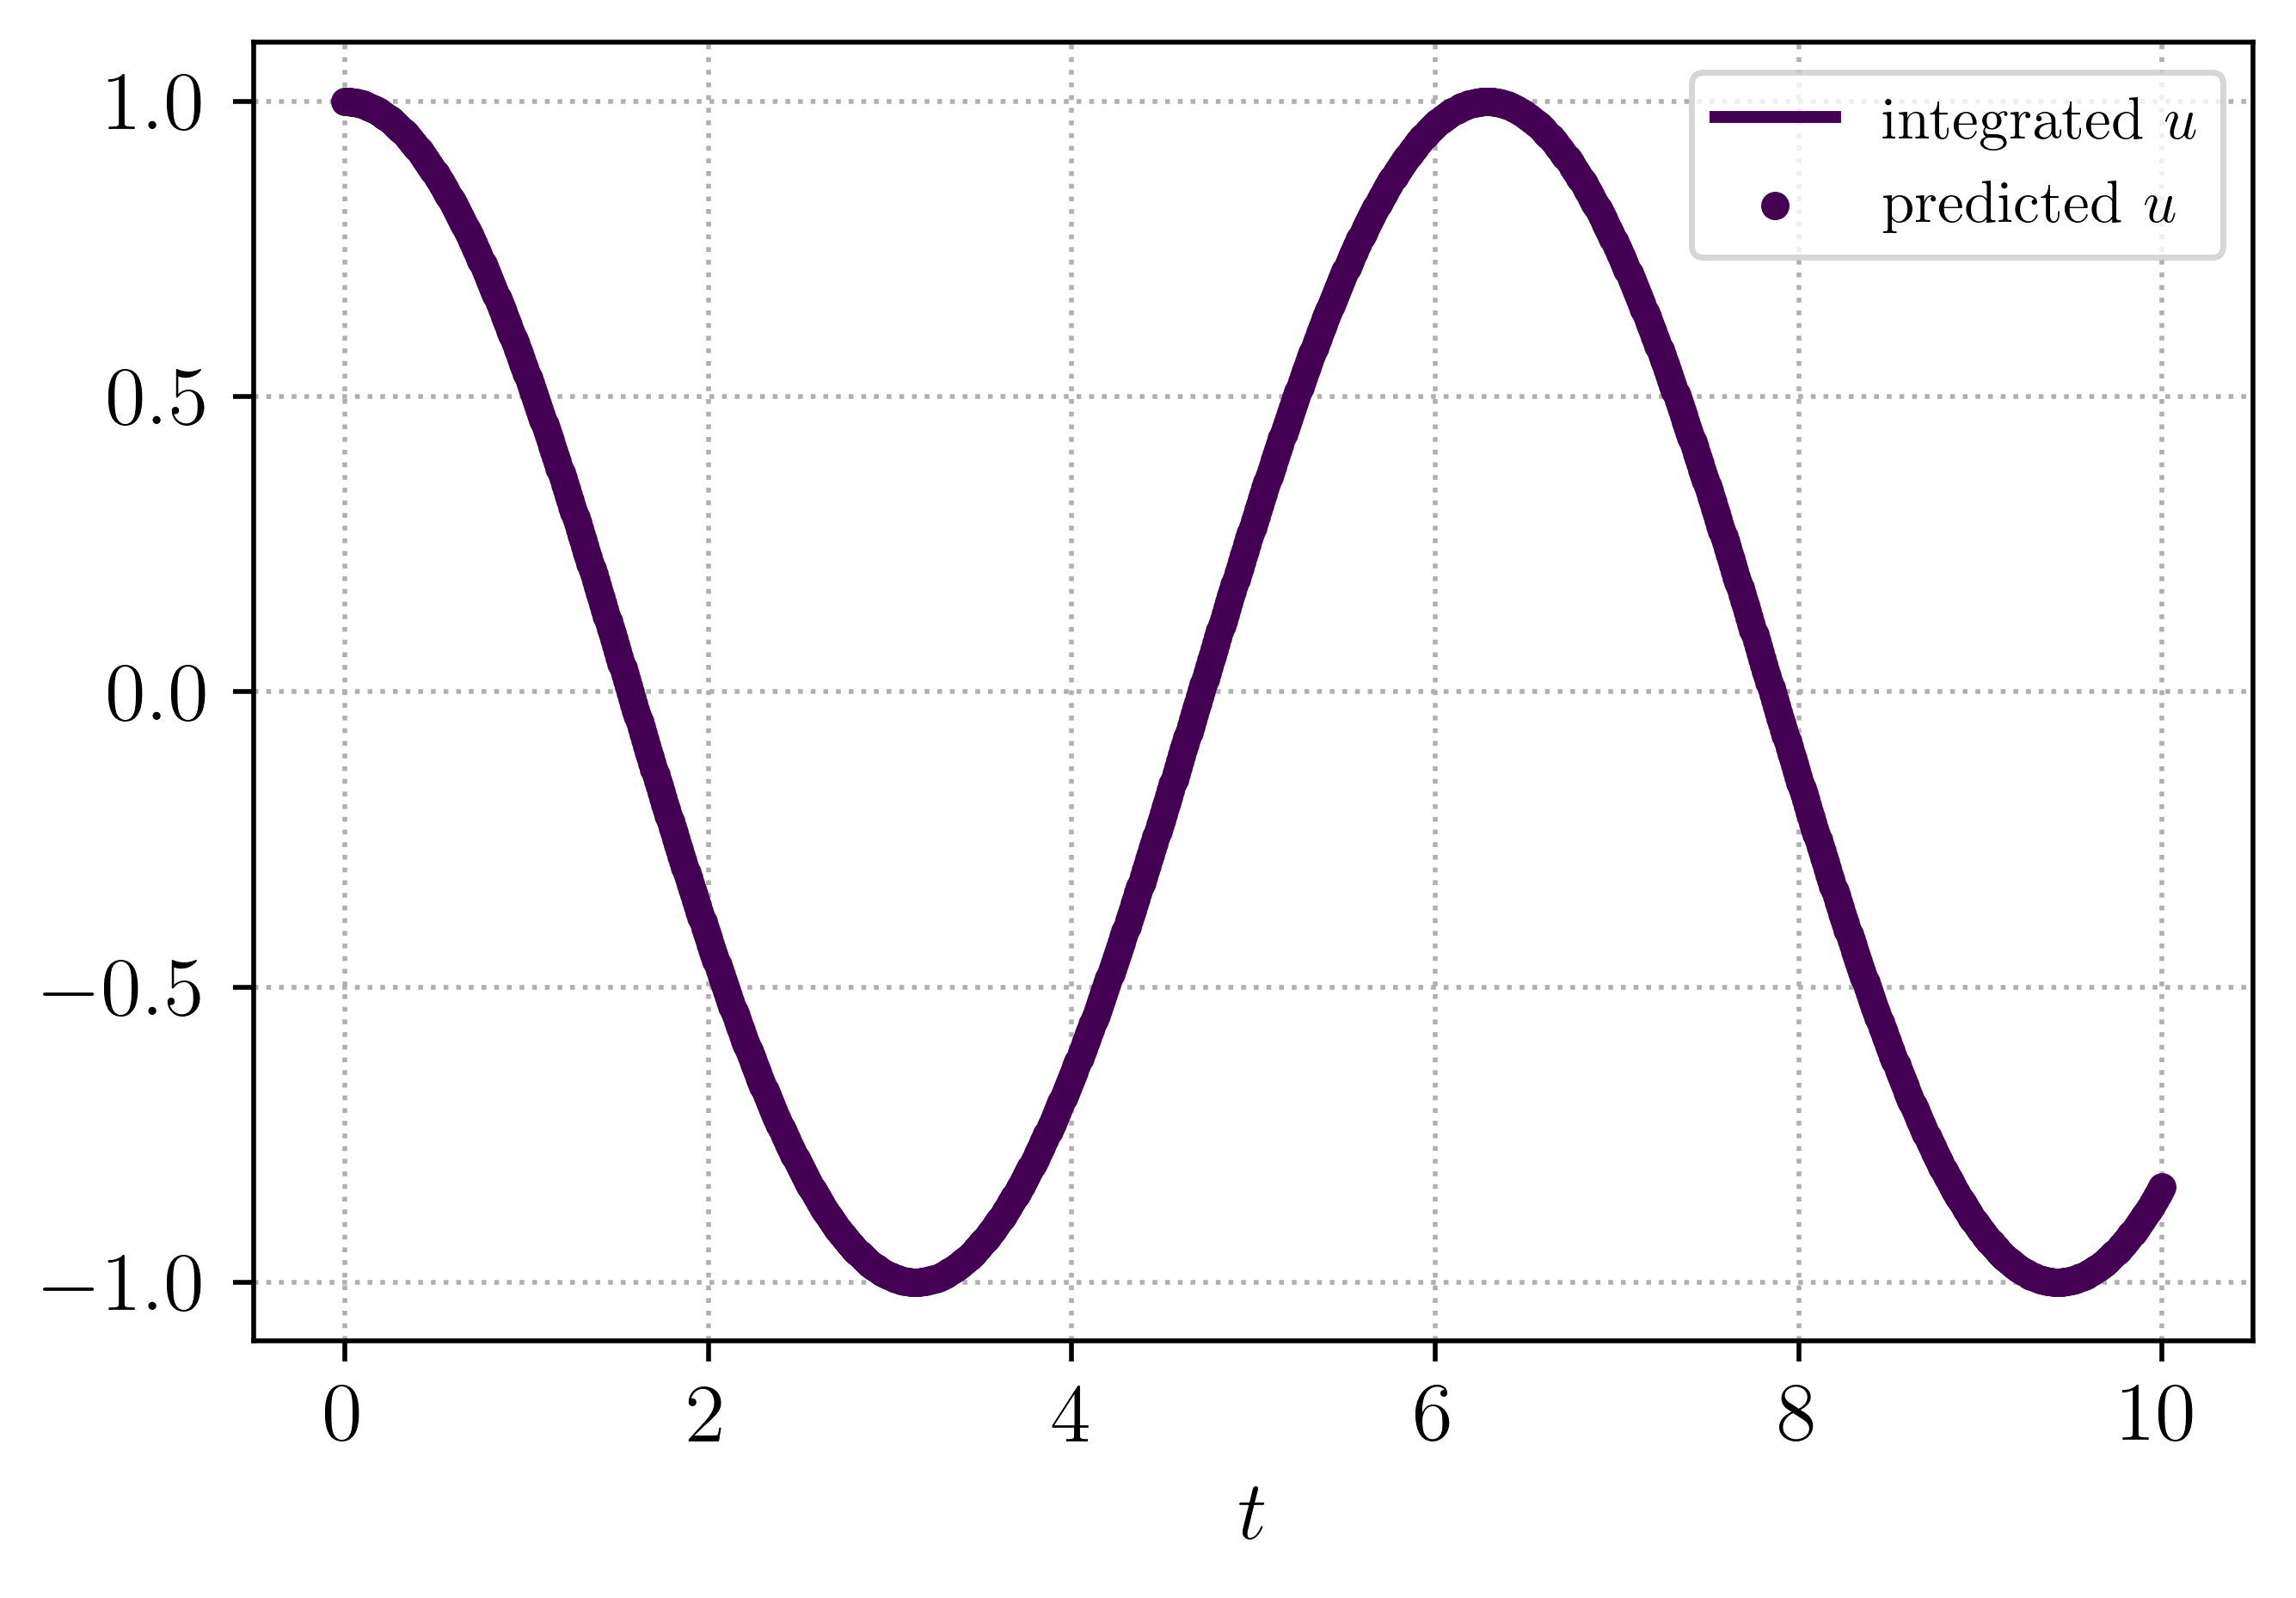

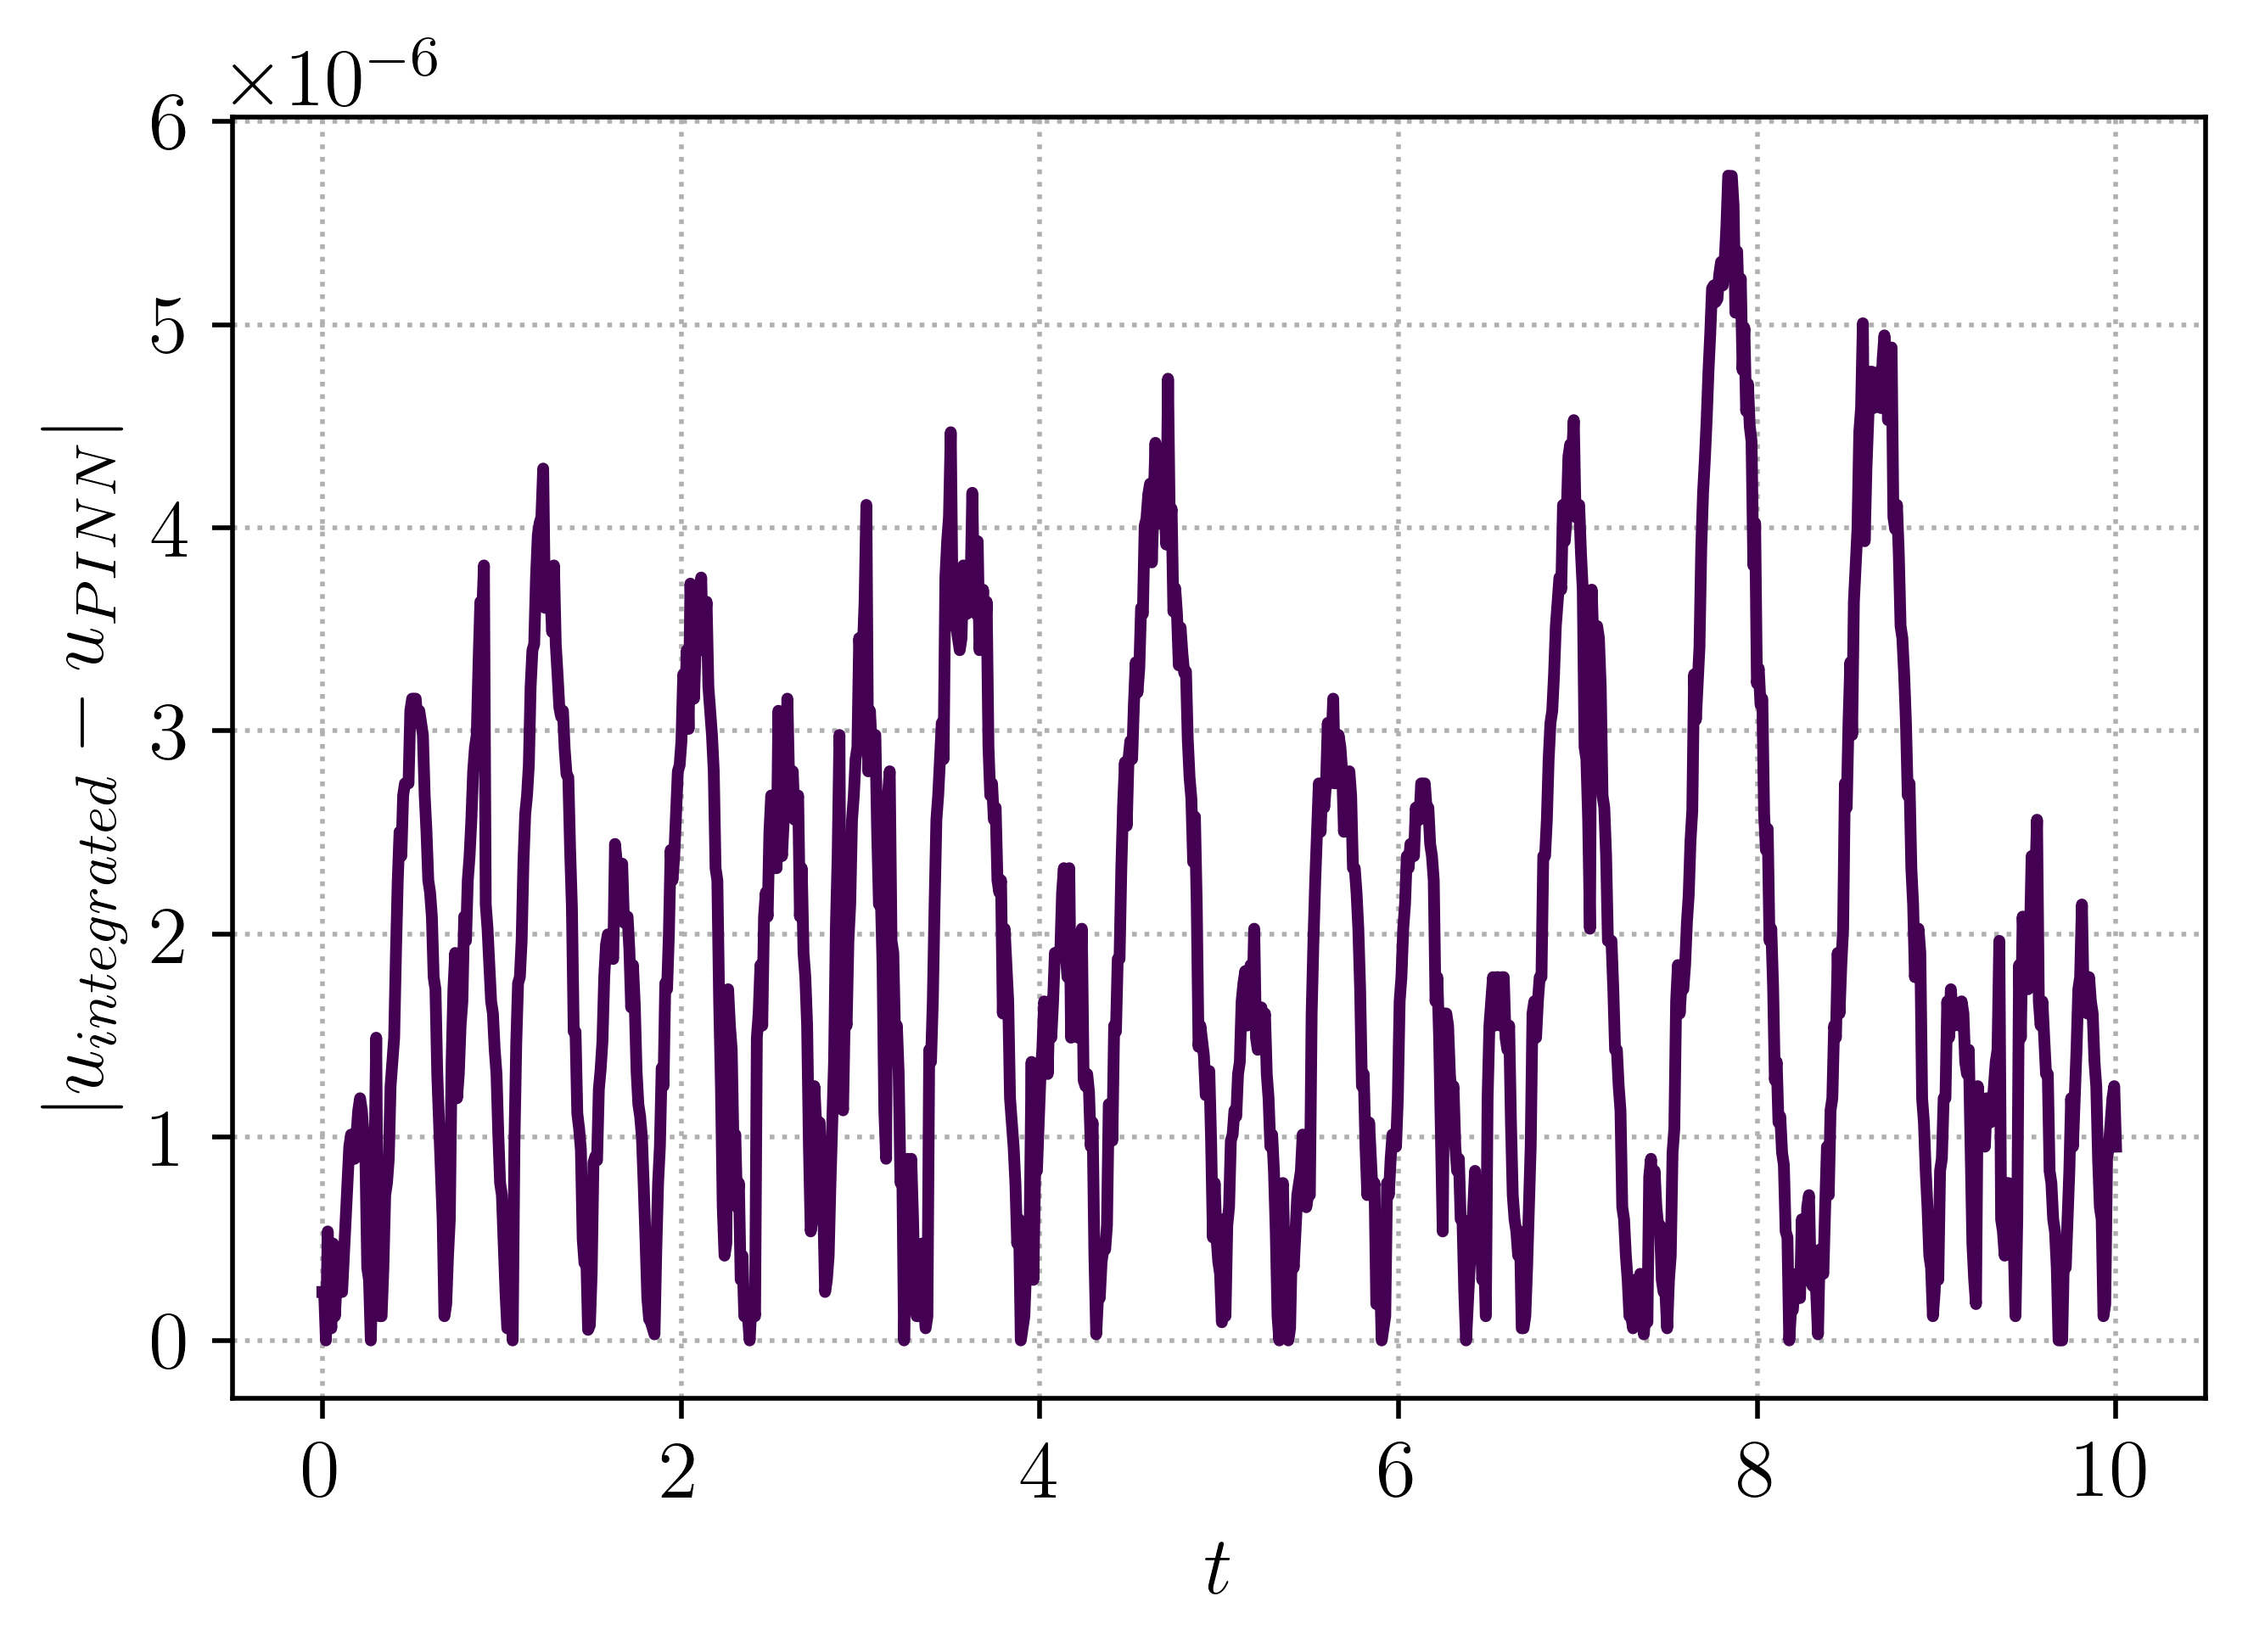

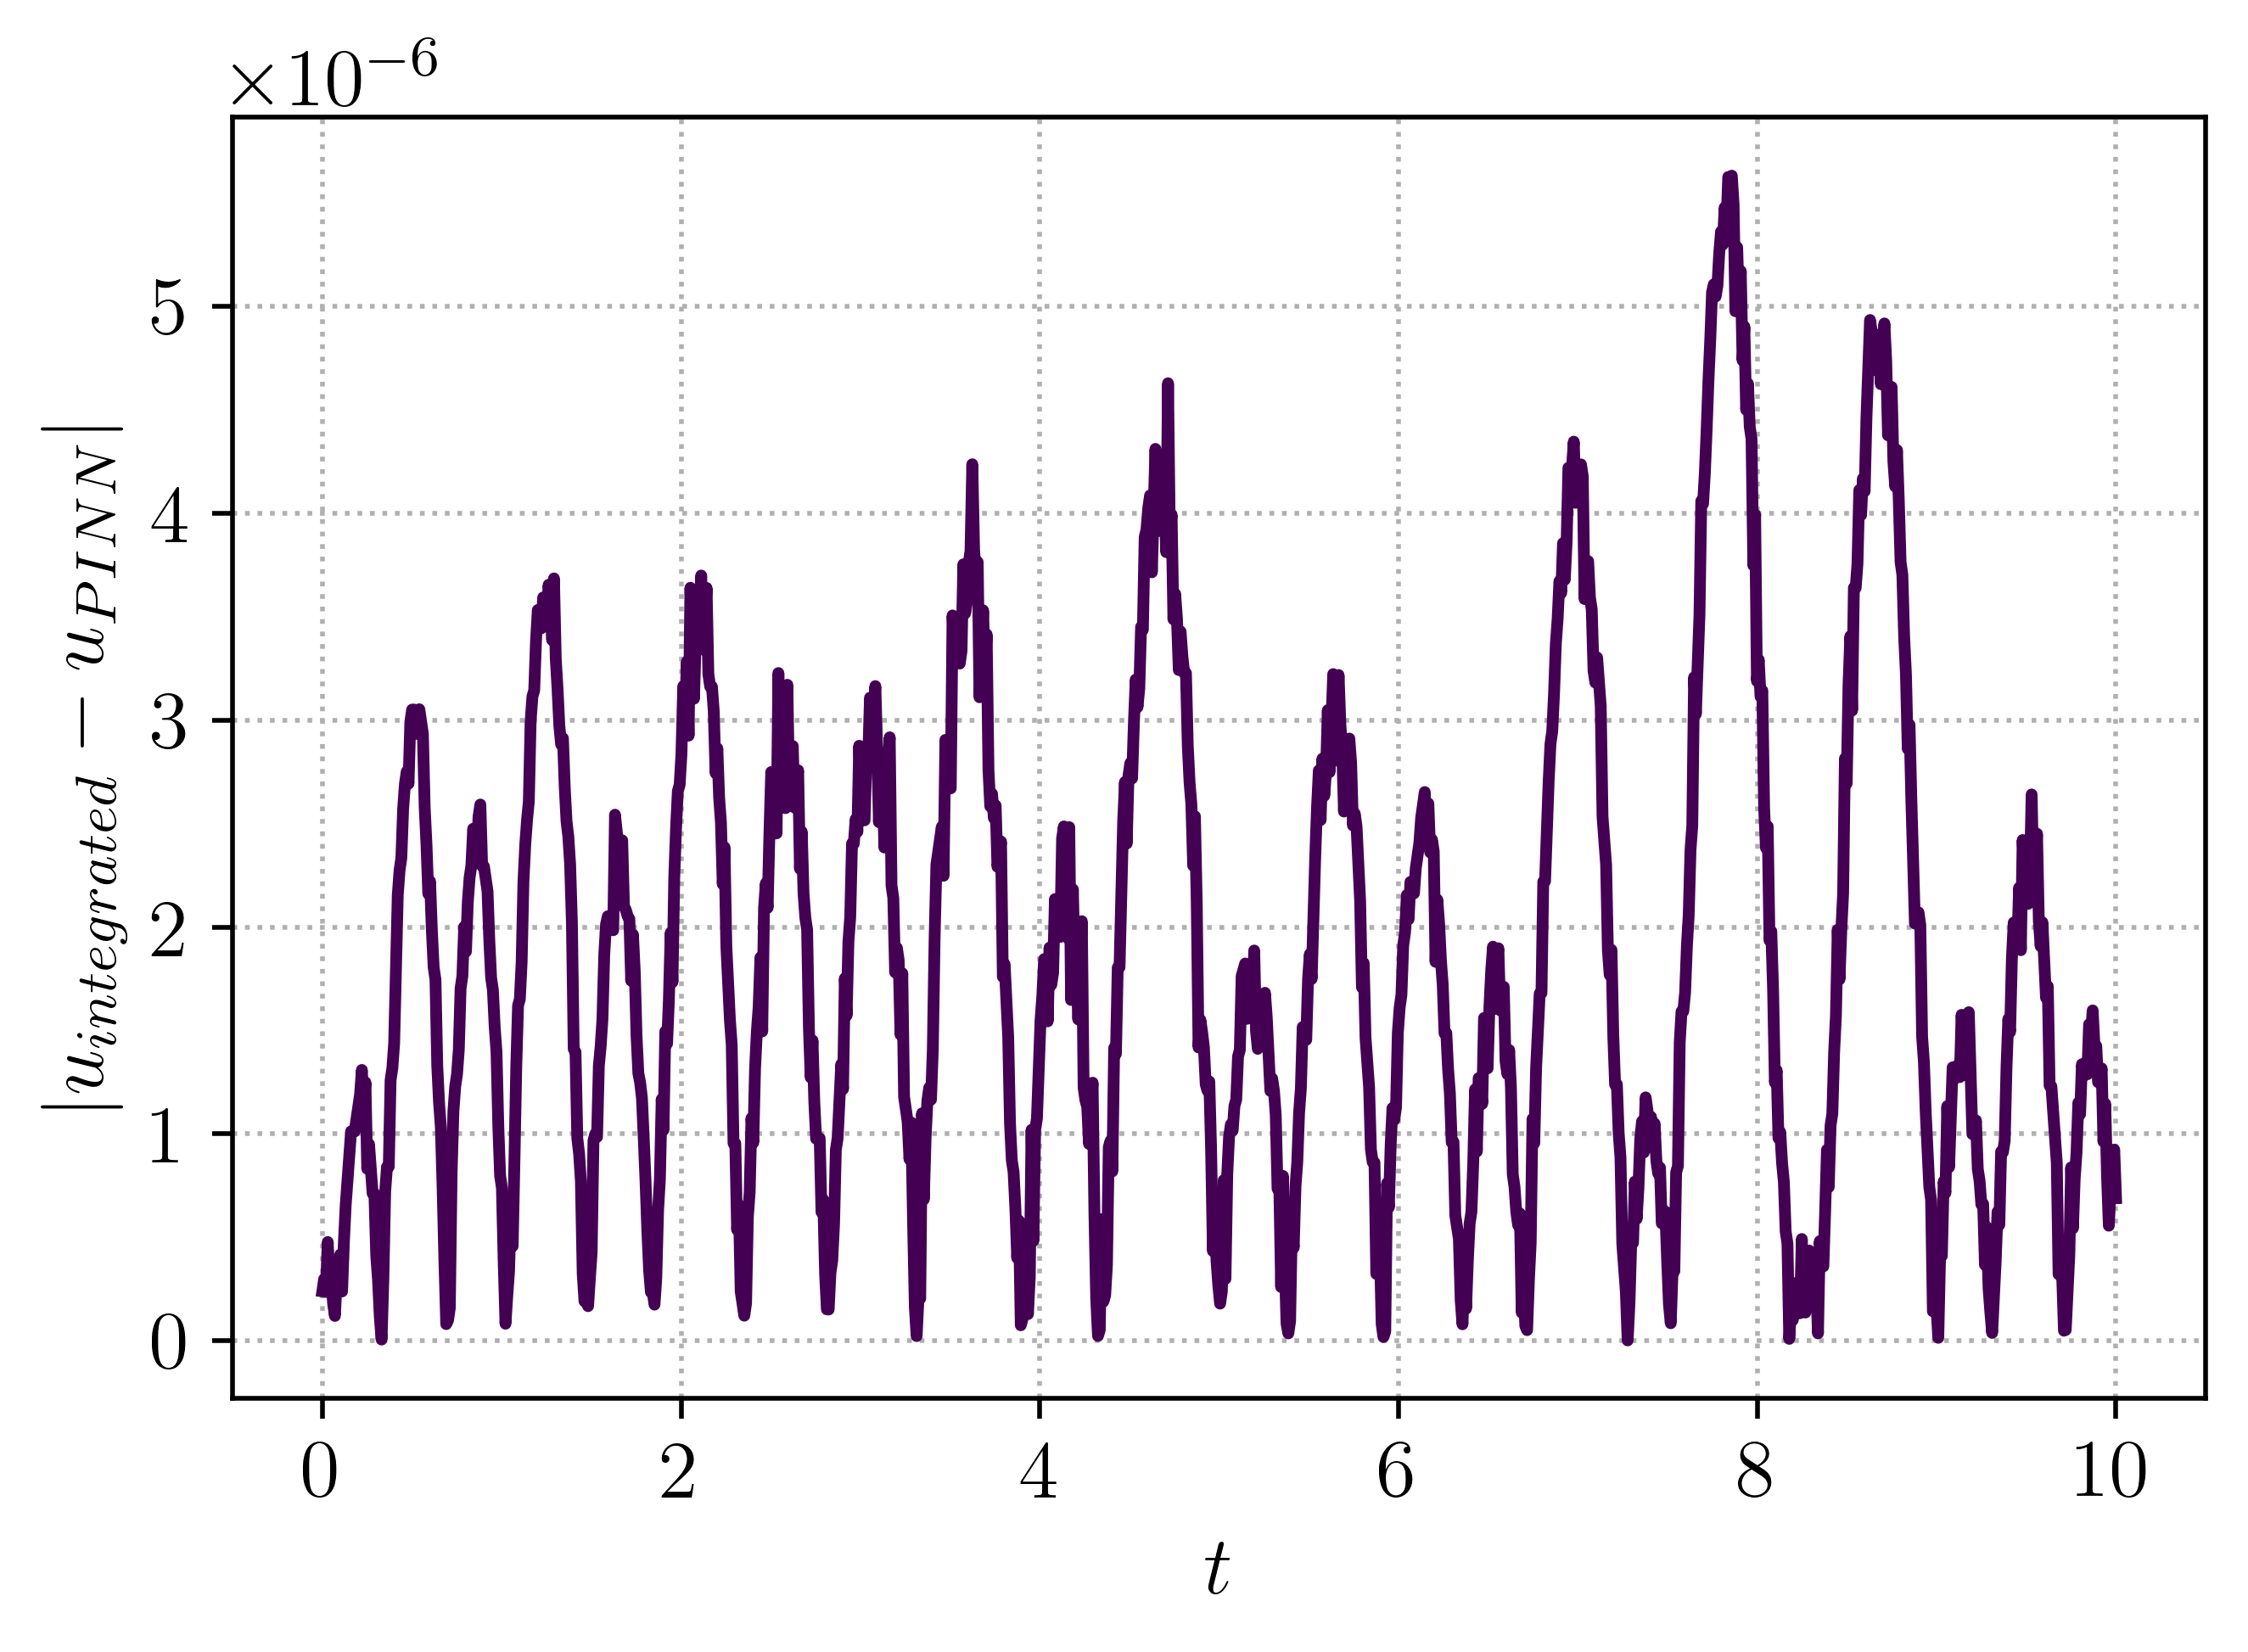

In [35]:
analytics.plot.plot_solution(eq_naive, paths[0] + '/best_setup', mpinn[0], model_wrapper[0], rescale[0])

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


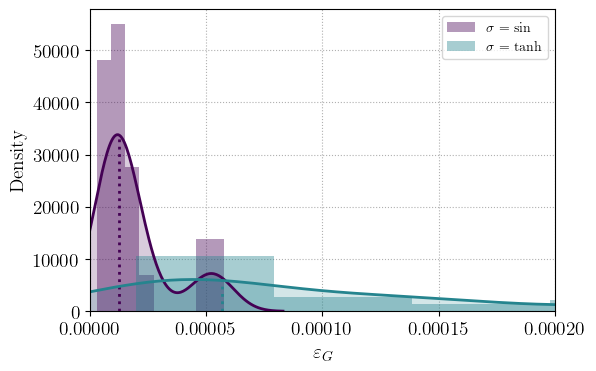

In [9]:
analytics.plot.plot_sensitivity(stashed_total[0], 'activation', r'$\sigma$', 'average_relative_L2_error', '.', line='median', xlim=(0., 0.0002))

In [51]:
plt.figure()
plt.grid(True, which='both', ls=':')
plt.scatter(stashed_total[0]['unweighted_total_loss'], stashed_total[0]['average_relative_L2_error'], label=r'naive')
plt.scatter(stashed_total[2]['unweighted_total_loss'], stashed_total[2]['relative_L2_error_full'], label=r'scale separation')
plt.scatter(stashed_total[3]['unweighted_total_loss'], stashed_total[3]['relative_L2_error_full'], label=r'scale separation -- mPINN', marker='x')
plt.xlabel(r'$\varepsilon_T$')
plt.ylabel(r'$\varepsilon_G$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('et_vs_eg.pdf')

Small scale performance

In [49]:
import PINNs.other

def get_vars_loss_other_scale(data, path_to_ensemble, eq_sep, mpinn, wrapper, rescale, ic, eq_small):
    """
    compute vars loss on some scale for the models where the scales are learned together
    """

    vars_loss_other_scale = list()
    for row in range(len(data)):
        model = PINNs.other.import_state_dict_model(path_to_ensemble + '/setup_' + str(
            data.iloc[row]['setup_id']) + '/retrain_' + str(data.iloc[row]['retrain_id']), eq_sep, mpinn, wrapper, rescale)

        u_pred_vars = list()
        u_train_vars = list()
        x_u = ic[0]
        x_u.requires_grad = True
        if x_u.shape[0] != 0:
            out = model(x_u)[:, 1]
            grad_out = torch.autograd.grad(
                out, x_u, grad_outputs=torch.ones_like(out), create_graph=True)[0][:, 0]
            u_pred_vars.append(out)
            u_pred_vars.append(grad_out)
            u_train_vars.append(ic[1][:, 0])
            u_train_vars.append(eq_small.v0(x_u)[:, 0])
        u_pred_tot_vars = torch.cat(u_pred_vars, 0)
        u_train_tot_vars = torch.cat(u_train_vars, 0)
        loss_vars = torch.mean(
            abs(u_pred_tot_vars - u_train_tot_vars) ** 2)
        vars_loss_other_scale.append(loss_vars.detach().item())
    data['vars_loss_other_scale'] = vars_loss_other_scale

In [50]:
get_vars_loss_other_scale(data[2], paths[2], eq_together, mpinn[2], model_wrapper[2], rescale[2], initial, eq_small)
data[2]['unweighted_total_loss_other_scale'] = data[2]['residual_loss_2'] + data[2]['vars_loss_other_scale']

In [51]:
get_vars_loss_other_scale(data[3], paths[3], eq_together, mpinn[3], model_wrapper[3], rescale[3], initial, eq_small)
data[3]['unweighted_total_loss_other_scale'] = data[3]['residual_loss_2'] + data[3]['vars_loss_other_scale']

In [52]:
stashed_small = list()
stashed_small.append(analytics.collect_ensemble_data.stash_retrainings(data[0], 'unweighted_total_loss_other_scale'))
stashed_small.append(stashed_total[1])
stashed_small.append(analytics.collect_ensemble_data.stash_retrainings(data[2], 'unweighted_total_loss_other_scale'))
stashed_small.append(analytics.collect_ensemble_data.stash_retrainings(data[3], 'unweighted_total_loss_other_scale'))

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


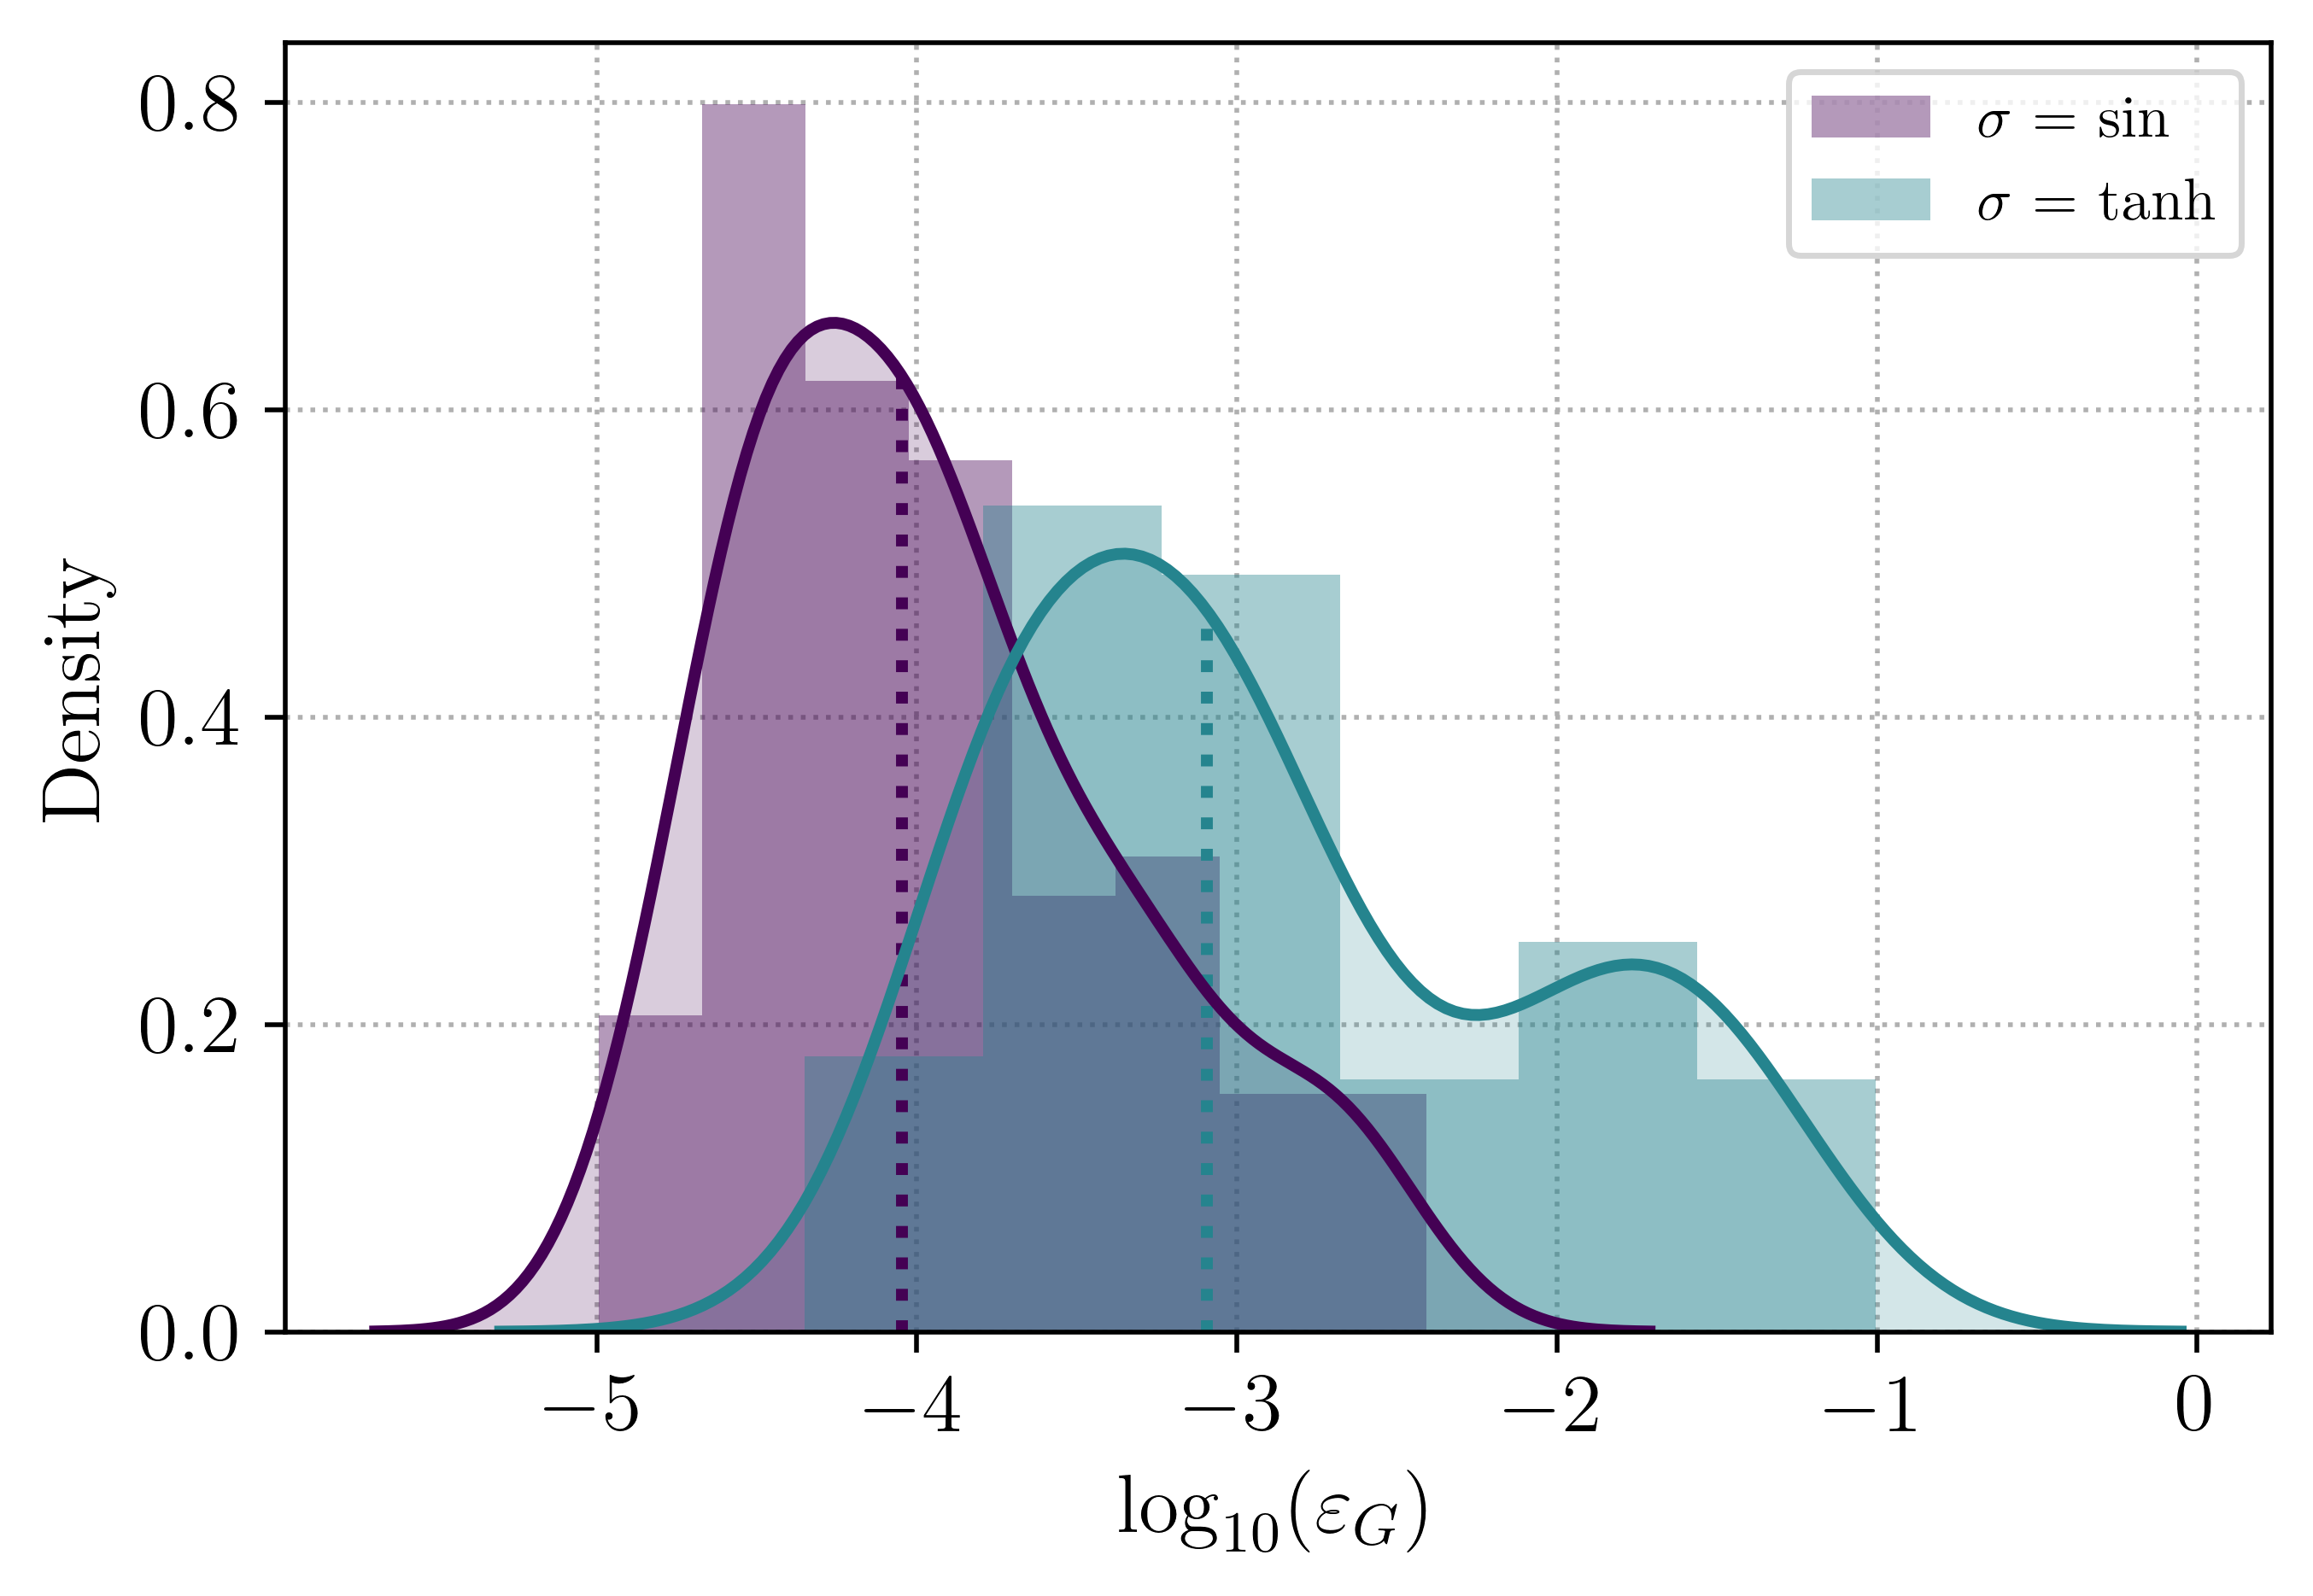

In [17]:
analytics.plot.plot_sensitivity(stashed_total[2], 'activation', r'$\sigma$', 'relative_L2_error_full', '.', line='median', xlog=True)

In [53]:
best_small = list()
best_small.append(analytics.collect_ensemble_data.get_best_setup(stashed_small[0], 'unweighted_total_loss_other_scale', paths[0]))
best_small.append(analytics.collect_ensemble_data.get_best_setup(stashed_small[1], 'unweighted_total_loss', paths[1]))
best_small.append(analytics.collect_ensemble_data.get_best_setup(stashed_small[2], 'unweighted_total_loss_other_scale', paths[2]))
best_small.append(analytics.collect_ensemble_data.get_best_setup(stashed_small[3], 'unweighted_total_loss_other_scale', paths[3]))

In [54]:
best_small_df = pd.concat(best_small, ignore_index=True)
best_small_df.to_csv('./best_small_duffing_' + str(args['c']) + '.csv')

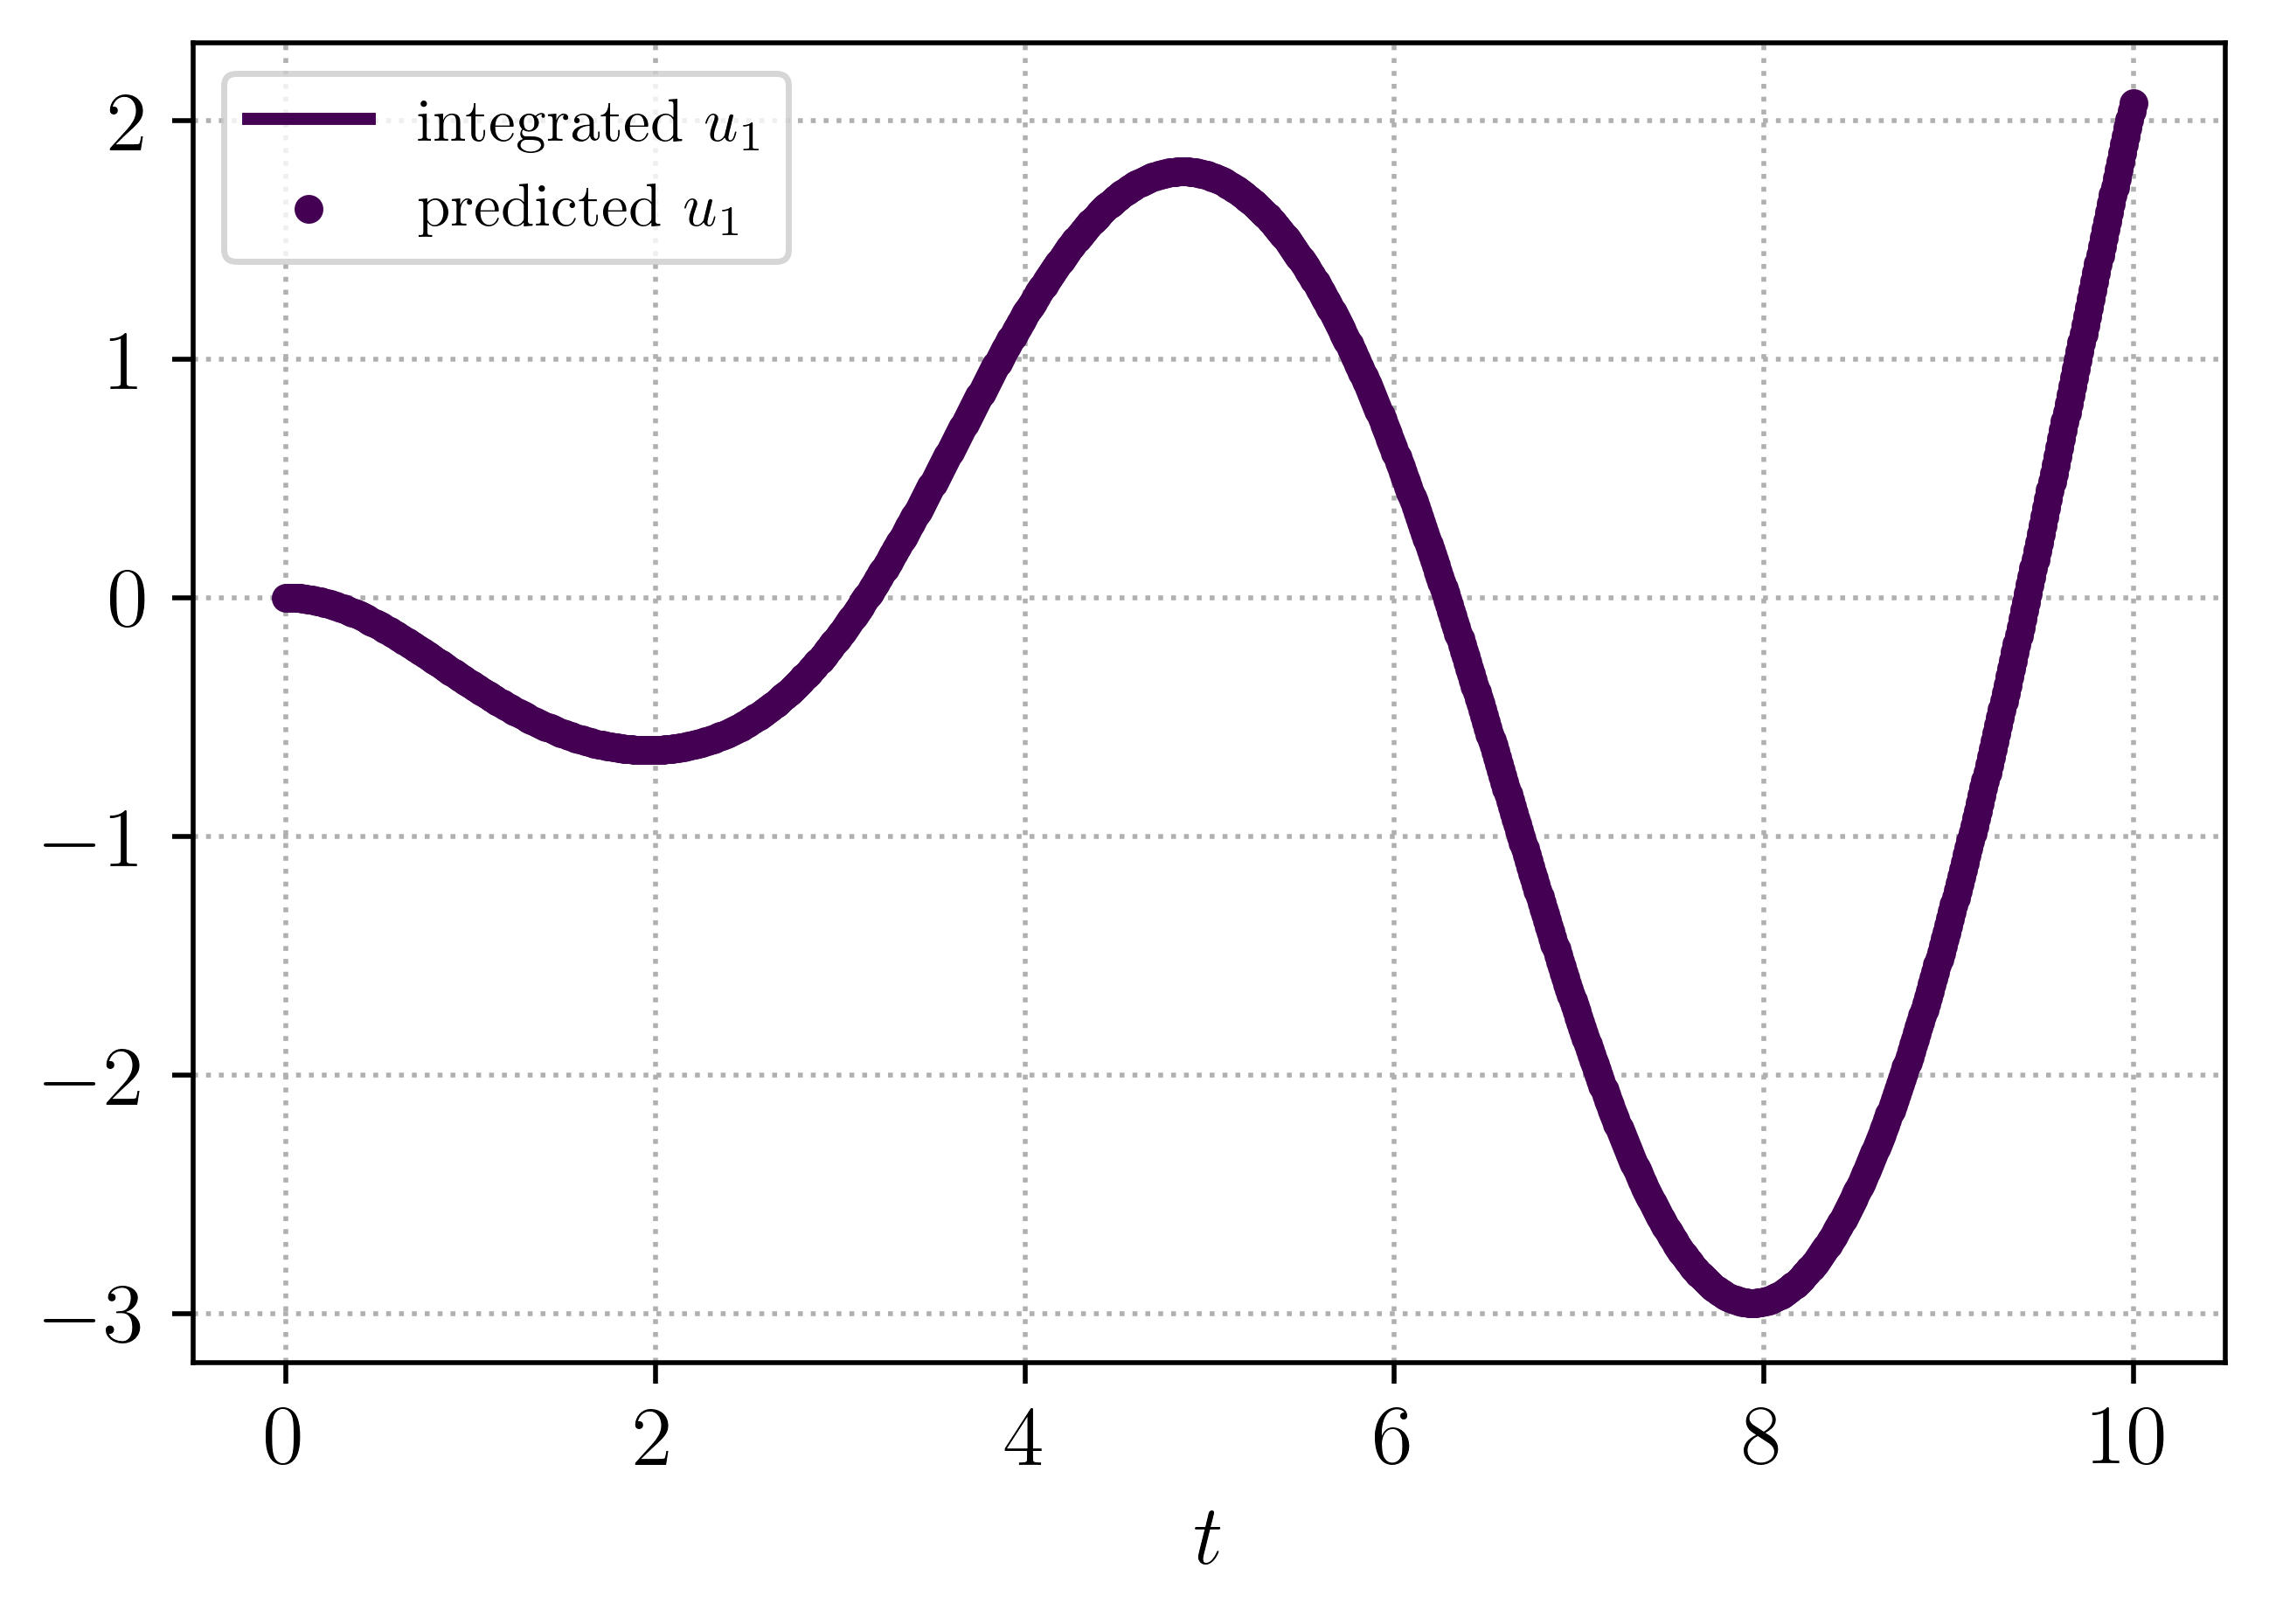

In [17]:
import PINNs

model = PINNs.other.import_state_dict_model(paths[3] + '/best_setup', eqs[3], mpinn[3], model_wrapper[3], rescale[3])

model.cpu()
model.eval()
x = torch.reshape(torch.linspace(
    extrema[0, 0], extrema[0, 1], 1000), [1000, 1])

exact = eq_small.integrated_sol(x)
#sol = (other_scale(model, x)[:, 0]).detach().numpy()
sol = model(x)[:, 1].detach().numpy()

plt.figure()
plt.grid(True, which="both", ls=":")
plt.plot(x, exact,
            linewidth=2, label=r'integrated $u_1$')
plt.scatter(x, sol,
            label=r'predicted $u_1$', marker="o", s=14)

plt.xlabel(r'$t$')
plt.legend()
plt.savefig(paths[3] + "/best_setup/best_small_scale.pdf")

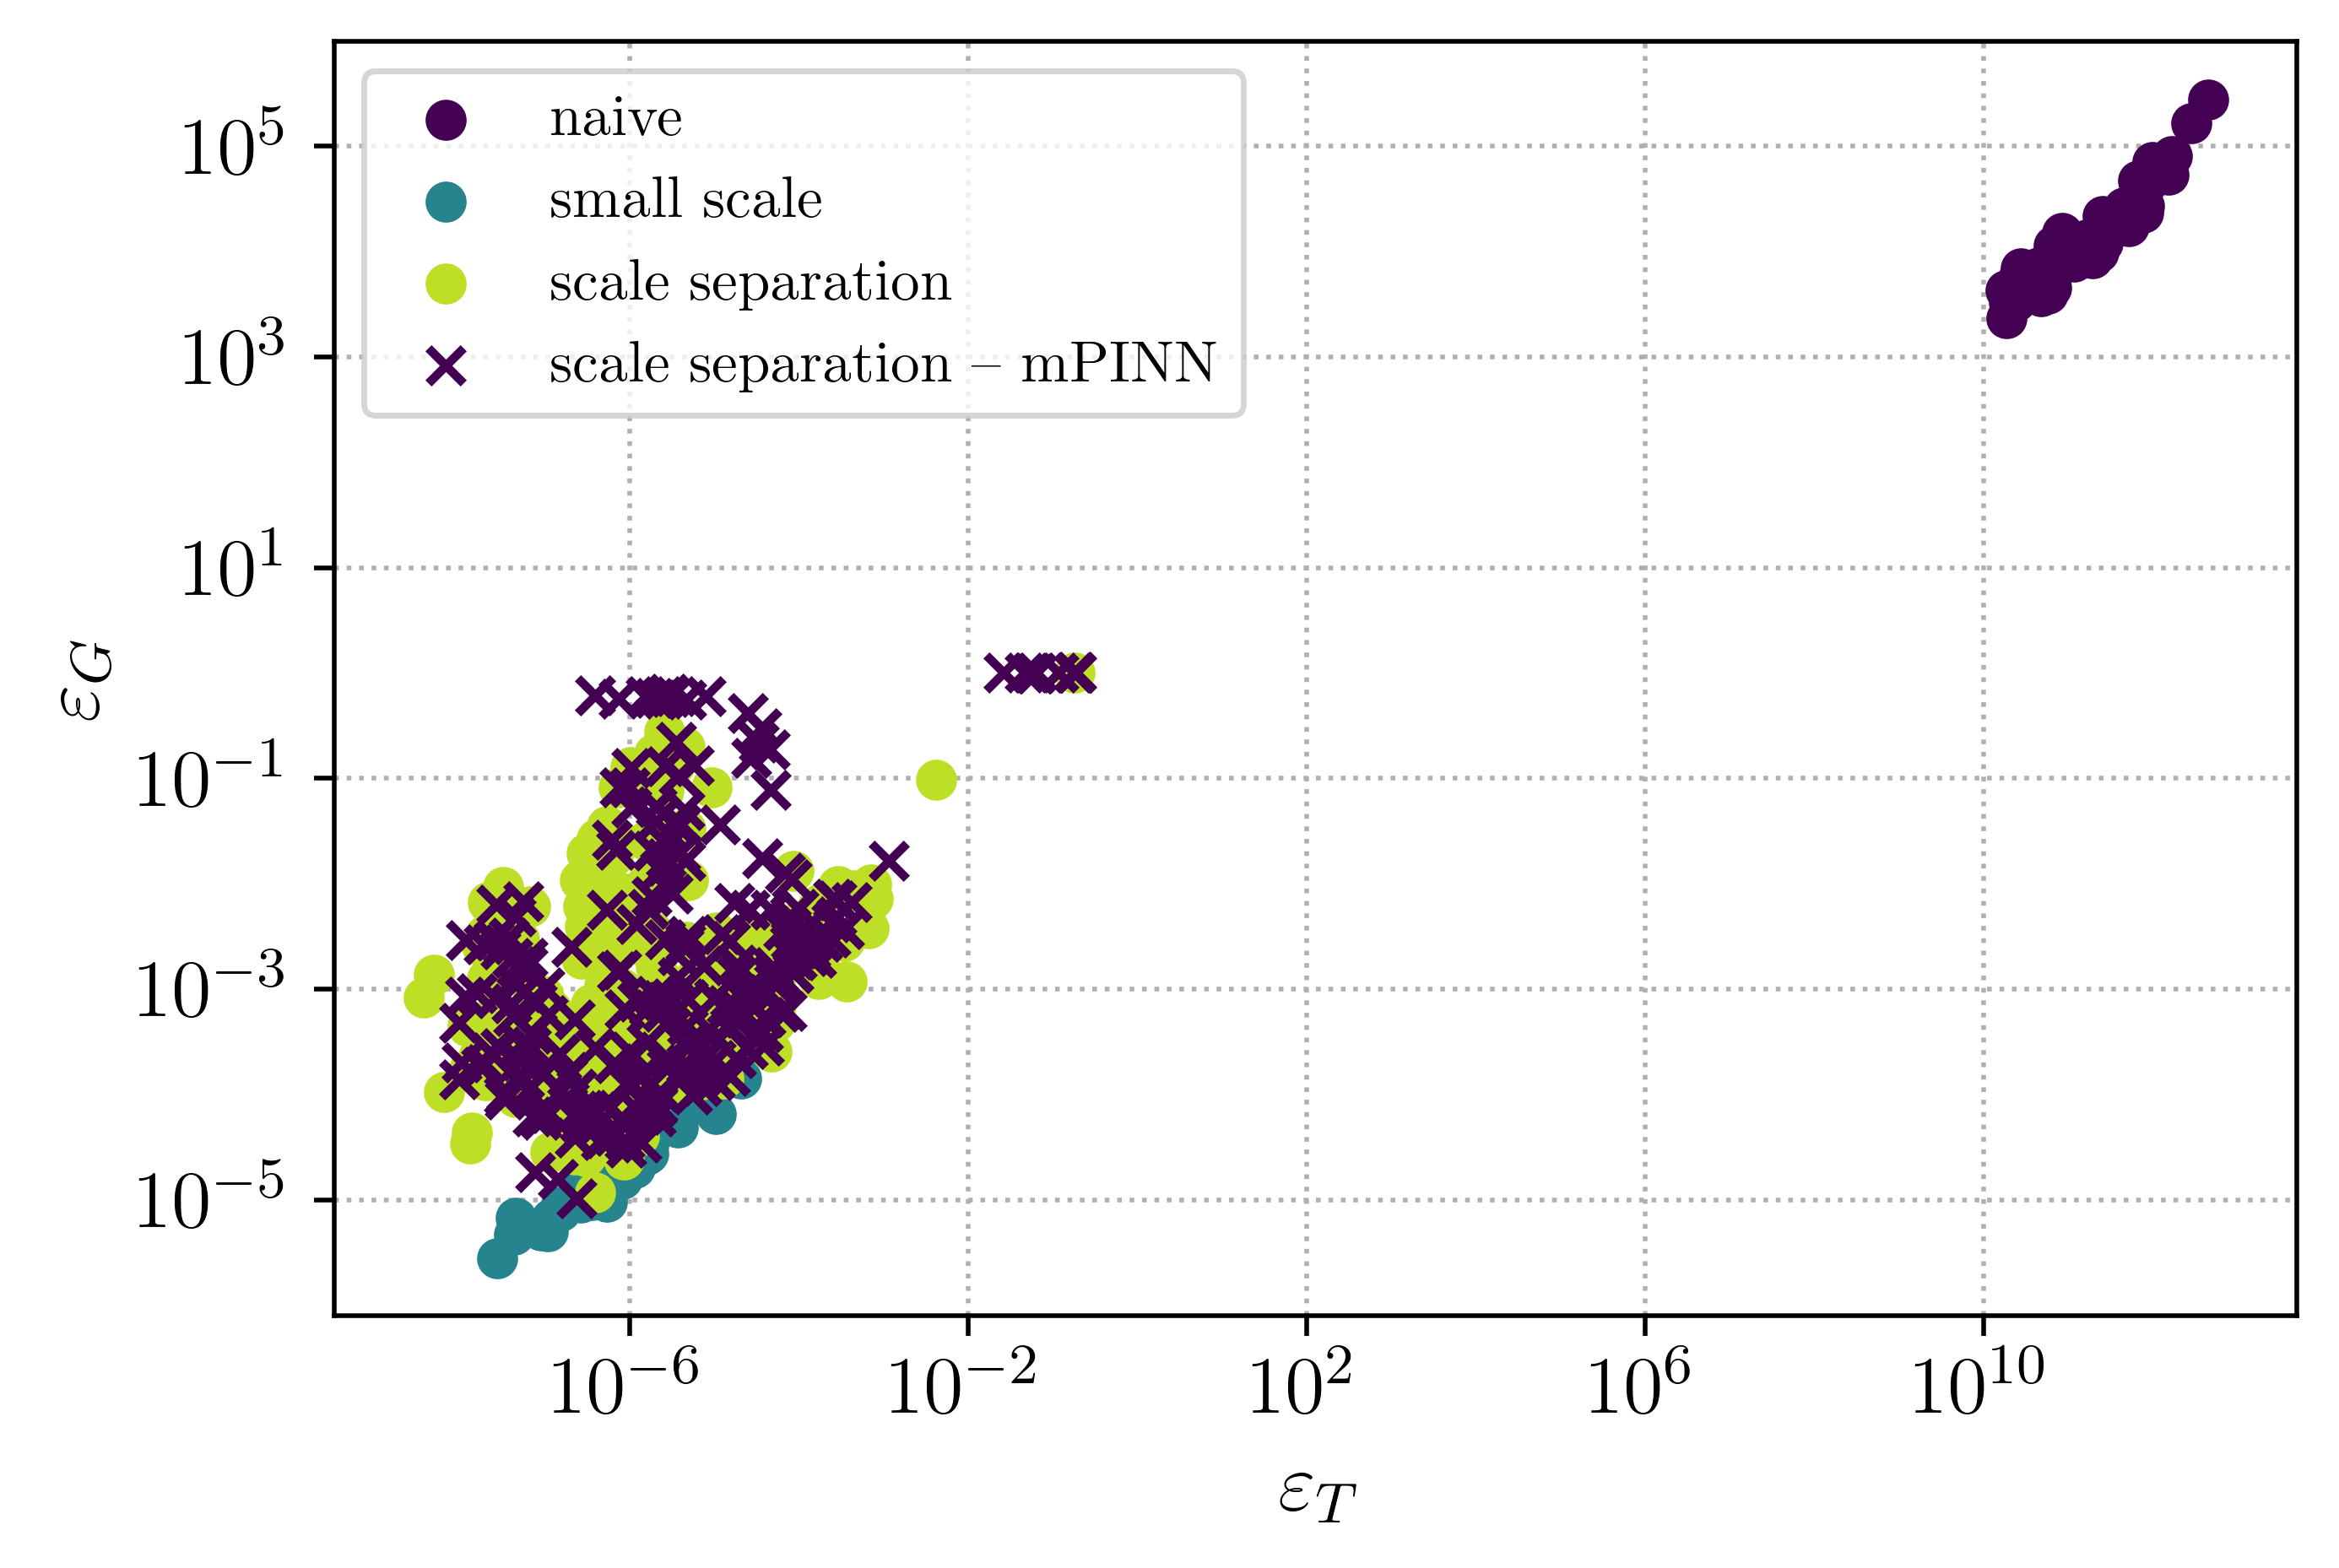

In [58]:
plt.figure()
plt.grid(True, which='both', ls=':')
plt.scatter(stashed_small[0]['unweighted_total_loss_other_scale'], stashed_small[0]['relative_L2_error_other_scale'], label=r'naive')
plt.scatter(stashed_small[1]['unweighted_total_loss'], stashed_small[1]['average_relative_L2_error'], label=r'small scale')
plt.scatter(stashed_small[2]['unweighted_total_loss_other_scale'], stashed_small[2]['relative_L2_error_2'], label=r'scale separation')
plt.scatter(stashed_small[3]['unweighted_total_loss_other_scale'], stashed_small[3]['relative_L2_error_2'], label=r'scale separation -- mPINN', marker='x')
plt.xlabel(r'$\varepsilon_T$')
plt.ylabel(r'$\varepsilon_G$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('et_vs_eg.pdf')

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

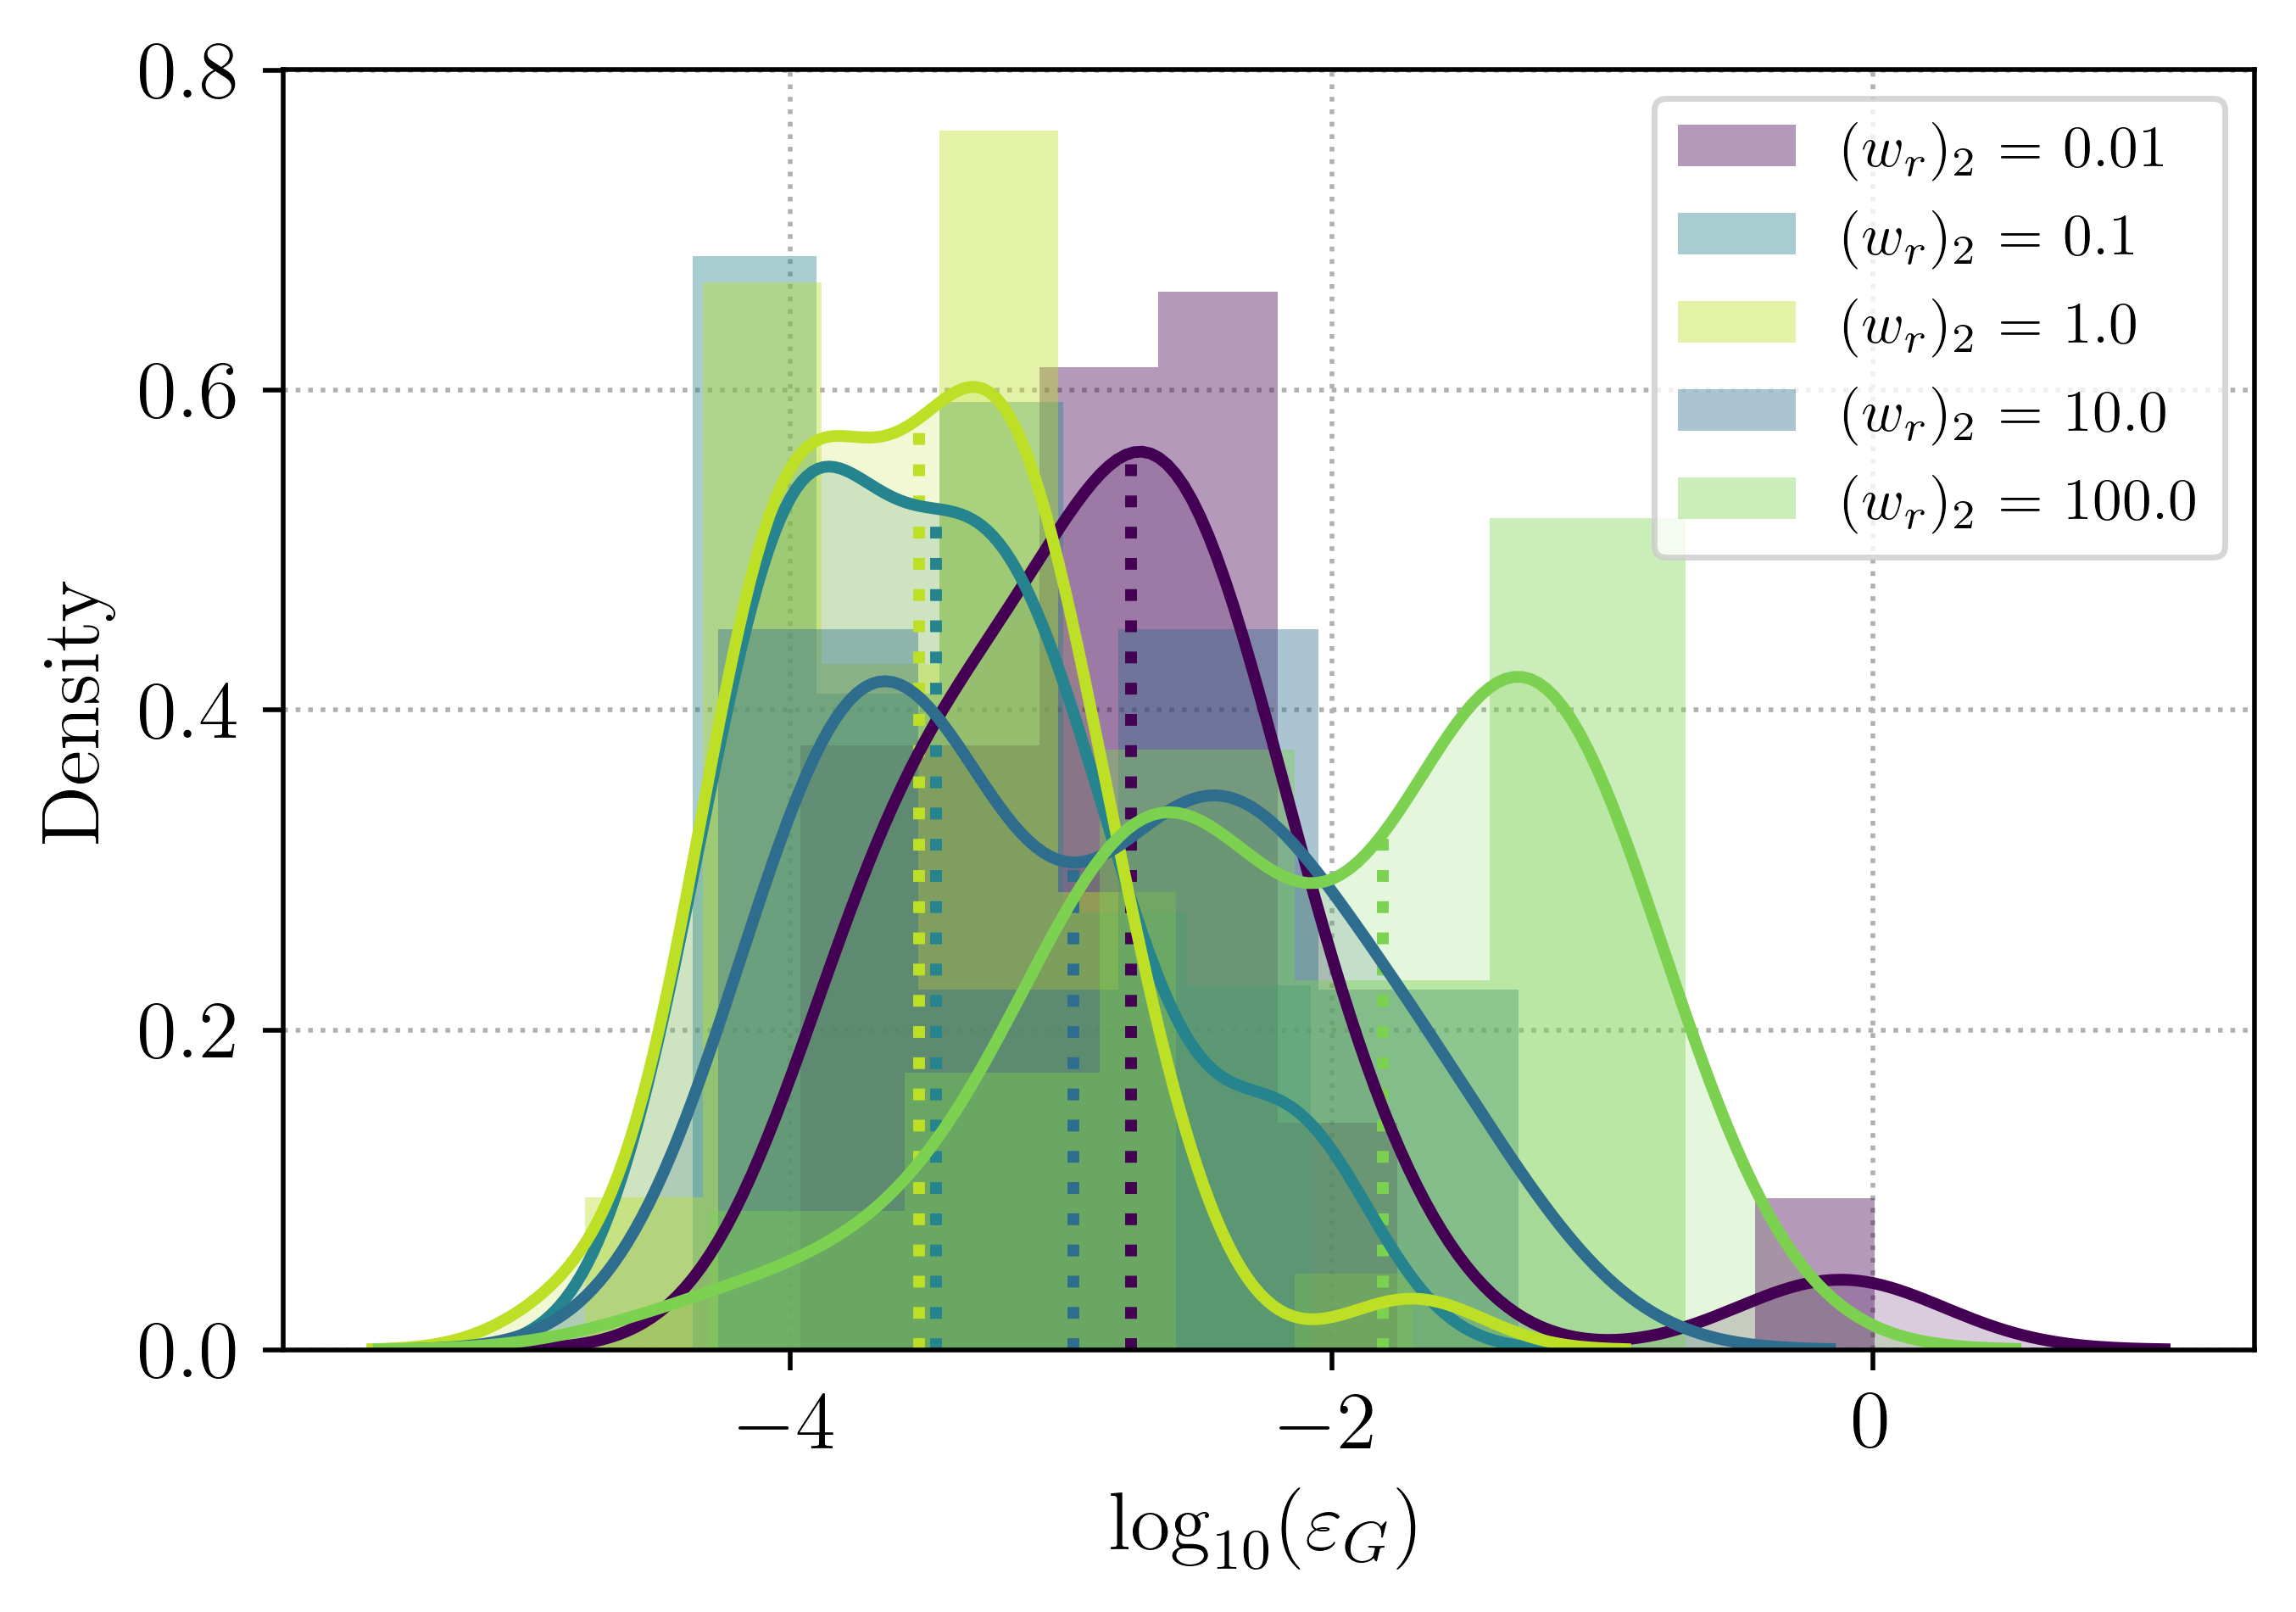

In [38]:
analytics.plot.plot_sensitivity(stashed_small[2], 'w_r_1', r'$(w_r)_2$', 'relative_L2_error_2', '.', line='median', xlog=True)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


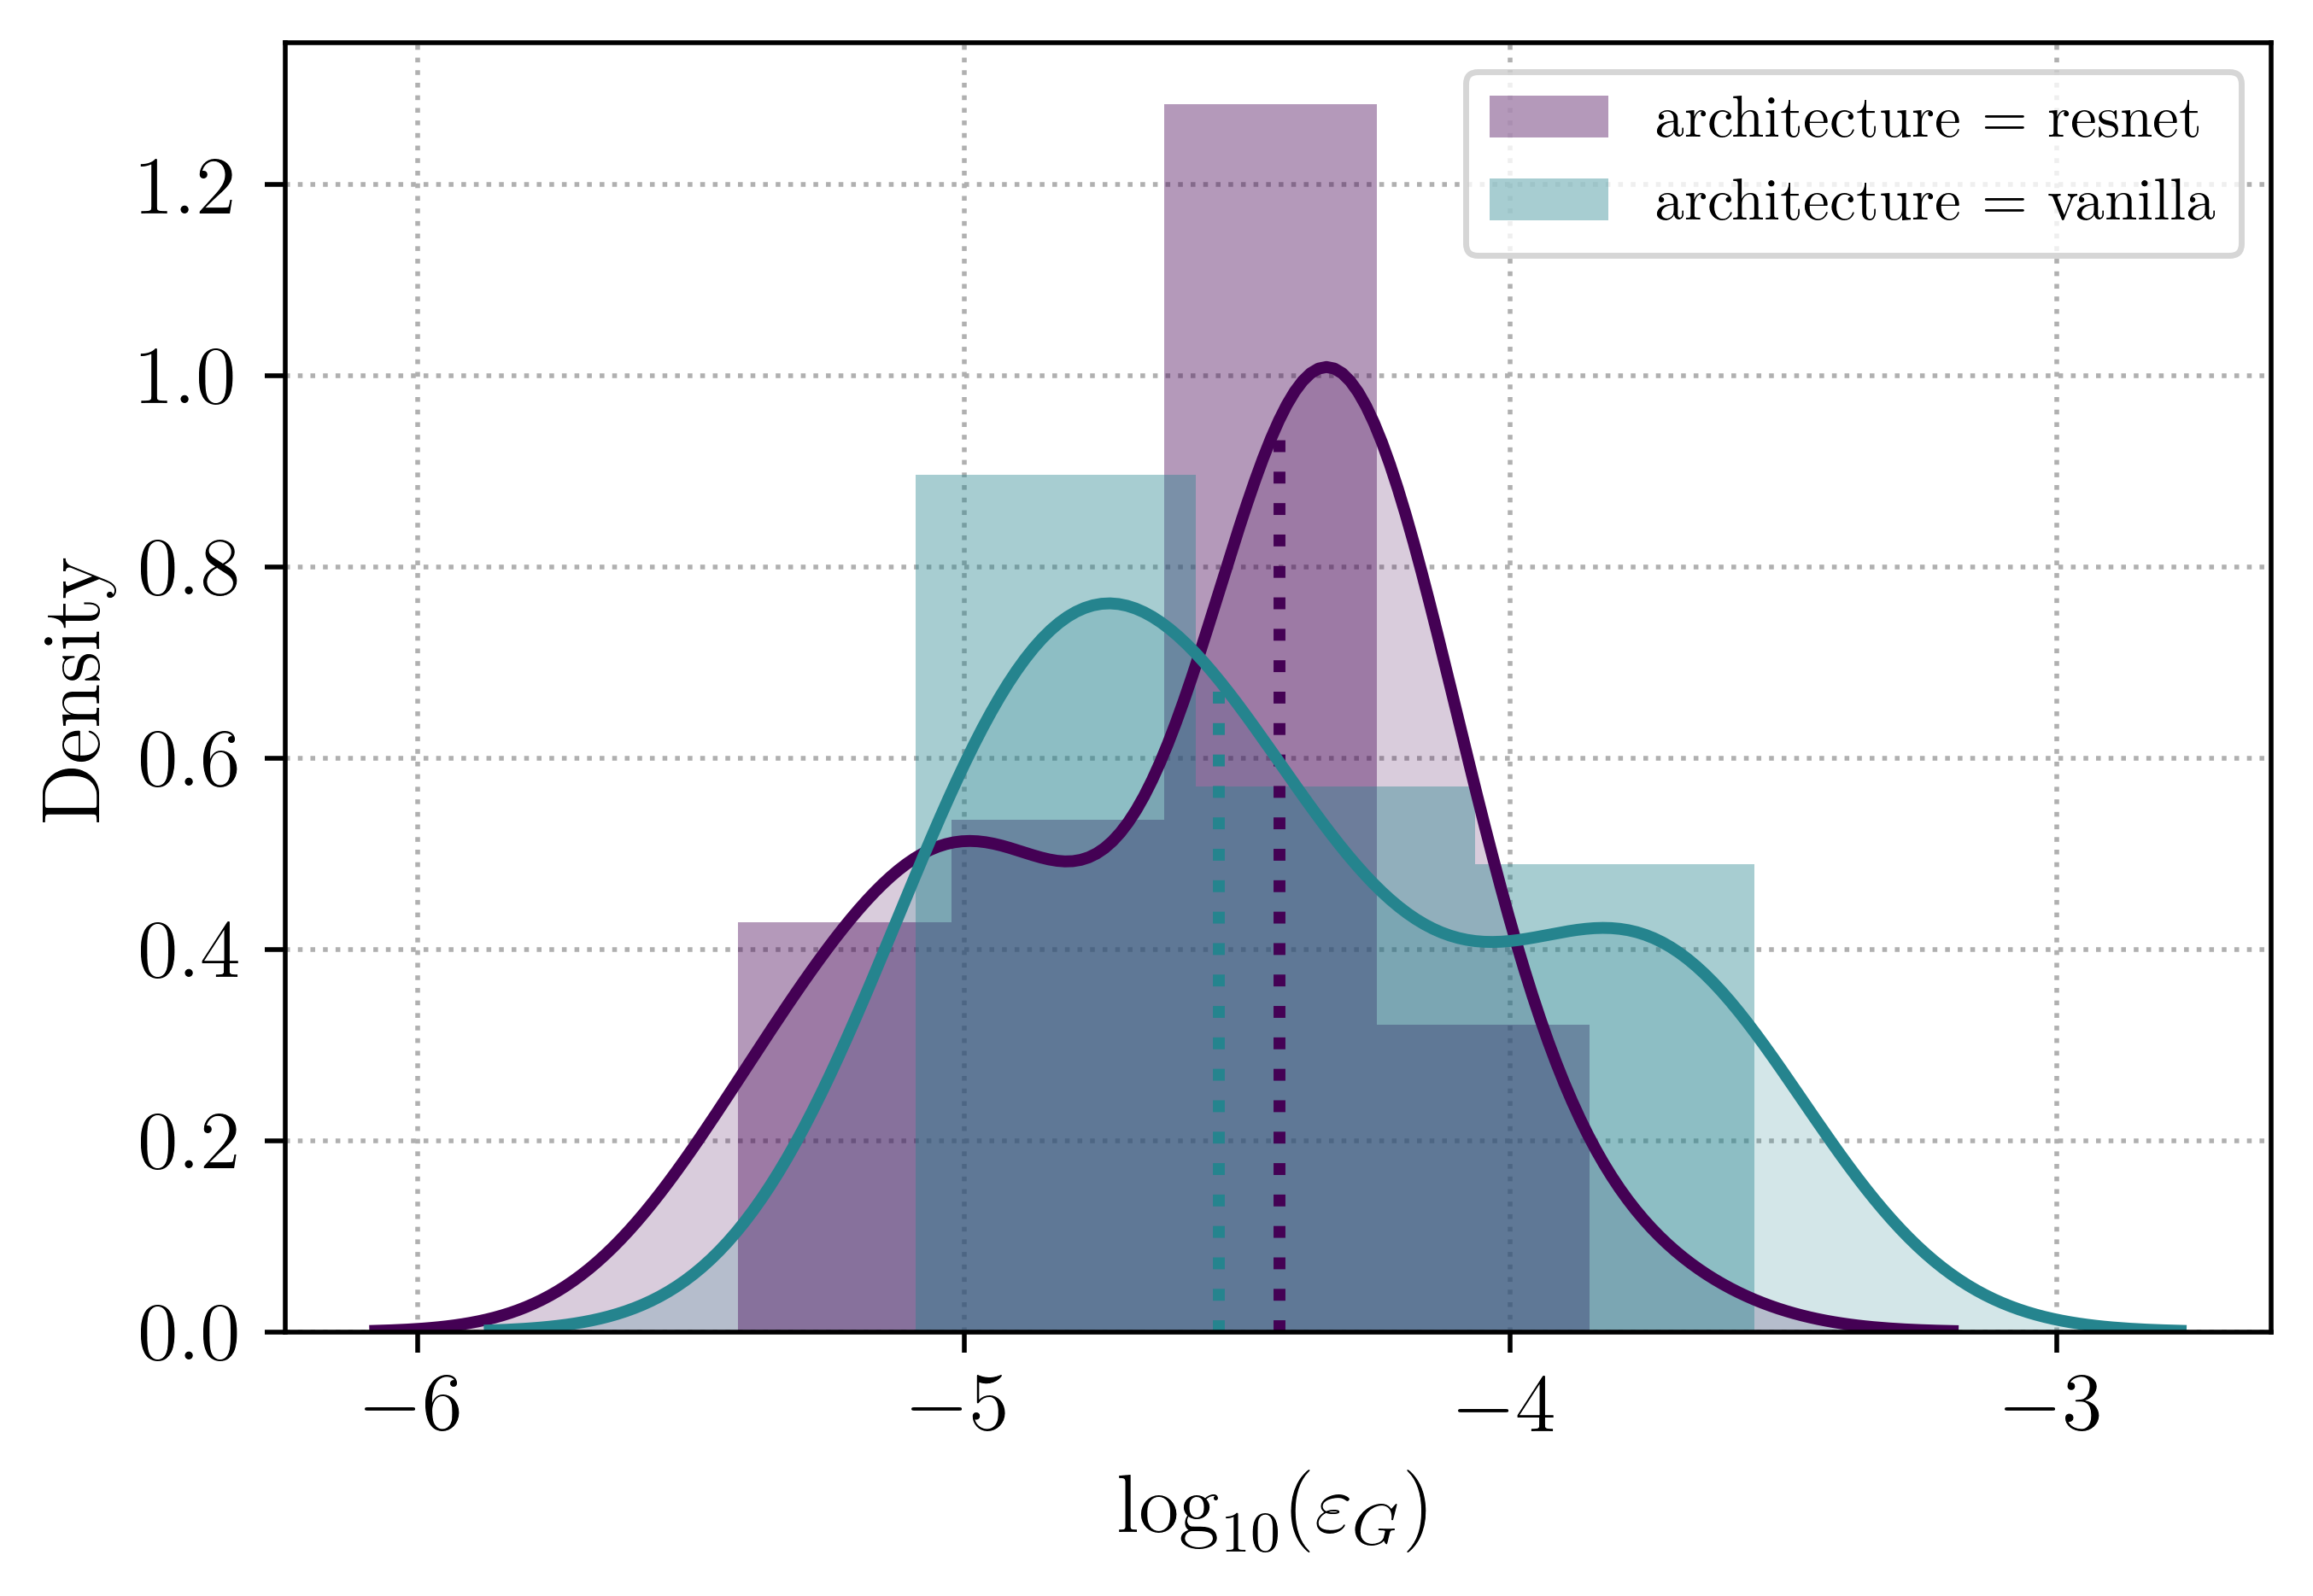

In [39]:
analytics.plot.plot_sensitivity(stashed_total[0], 'model', r'architecture', 'average_relative_L2_error', '.', line='median', xlog=True)